# La régression logistique régularisée à noyau
*Notebook réalisé par Ethan Trentin*

Chargement des packages utilisés pendant la session.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

#### Question 1 :     
La vraisemblance du modèle s'écrit :
$\mathcal{L}(\beta) = \prod_{i=1}^n \mathbb{P}(Y=y_i|X=x_i)=\prod_{i=1}^n \pi(x_i)^{y_i} (1-\pi(x_i))^{1-y_i}$
En passant à la log-vraisemblance, $L(\beta) = log(\mathcal{L}(\beta)) = \sum_{i=1}^n y_ilog(\pi(x_i)) + (1-y_i)log(1-\pi(x_i))$.

#### Question 2 :       

On veut maintenant trouver $\hat{\beta}=[\hat{\beta_0}, ...., \hat{\beta_p}]^T$.
$$L(\beta) = \sum_{i=1}^n y_ilog(\frac{\pi(x_i)}{1-\pi(x_i}) + log(1-\pi(x_i))=\sum_{i=1}^n [y_i(\beta_0+\sum_{j=1}^p \beta_jx_{ij}) - log(1+exp(\beta_0+\sum_{j=1}^p \beta_jx_{ij}))]$$
En calculant le gradiant :      
$U(\beta) = \nabla_{\beta} L = X^T(y-\pi)$, on ne peut pas obtenir de solution analytique.

Pour maximiser la log-vraisemblance, on utilise l'algorithme de Newton-Raphson qui nécessite le calcul des dérivées secondes de la log-vraisemblance.
En notant H la matrice Hessienne, on obtient :    
$$[H(\beta)]_{jk} = \frac{\partial^2 L}{\partial \beta_j \partial \beta_k} = - \sum_{i=1}^n x_{ij}x_{ik}\pi_i(1-\pi_i)$$
$$H(\beta) = \frac{\partial^2 L}{\partial \beta \partial \beta^T} = - \sum_{i=1}^n x_{i}x_{i}^T\pi_i(1-\pi_i) = - X^T V X$$

On part d'une valuer arbitraire de départ $\beta^{(0)}$. Le développement de Taylor à l'ordre 2 de $L(\beta)$ autour de $\beta^{(s)}$ donne :     
$$L(\beta) \simeq L(\beta^{(s)})+[\frac{\partial L}{\partial \beta}(\beta^{(s)})]^T (\beta-\beta^{(s)})+\frac{1}{2}(\beta-\beta^{(s)})^T H(\beta^{(s)})(\beta-\beta^{(s)})$$
Alors, on obtient $\beta^{(s+1)}$ avec la valeur de $\beta$ maximisant la partie de droite de l'équation ci-dessus. On annule alors la dérivée de ce membre par rapport à $\beta$.
$$U(\beta^{(s)})+H(\beta^{(s)})(\beta^{(s+1)}-\beta^{(s)})=0$$
$$\beta^{(s+1)}=\beta^{(s)}-H(\beta^{(s)})^{-1}U(\beta^{(s)})$$
En remplaçant par les expressions obtenues précédemment, nous obtenons :      
$$\beta^{(s+1)}=\beta^{(s)}+(X^TV^{(s)}X)^{-1}X^T(y-\pi^{(s)})$$

#### Question 3 :

En majorant $\pi_i(1-\pi_i)$ par $\frac{1}{4}$, on peut écrire que :
$$H_1 = -X^TVX = -\sum_{i=1}^n x_ix_i^T \pi_i (1-\pi_i) \ge -\frac{1}{4}\sum_{i=1}^n x_ix_i^T = -\frac{1}{4} X^TX=H_2$$
$H_1-H_2=X^T(\frac{1}{4}I_n-V)X$ est une matrice définie positive.
Donc $H_2 = -\frac{1}{4} X^TX$.

#### Question 4 :      
On avait le résultat suivant :      
$$\beta^{(s+1)}=\beta^{(s)}+(X^TV^{(s)}X)^{-1}X^T(y-\pi^{(s)})$$
En y injectant l'approximation de la question 3, on obtient :       
$$\beta^{(s+1)}=\beta^{(s)}+4(X^TX)^{-1}X^T(y-\pi^{(s)})$$
$$\beta^{(s+1)}=\beta^{(s)}+4X^{-1}(y-\pi^{(s)})$$

#### Question 5 :      
Le modèle de régression logistique pénalisée nous fait considérer le maximumm de vraisemblance pénalisé, permettant de réduire le sur-apprentissage. Le modèle choisi sera donc moins compliqué et généralisera mieux à la fin. La stabilité et la précision sur les nouvelles données seront améliorées. Enfin, cela réduit l'impact de la multicolinéarité entre les coefficients en baissant l'influence des coefficients avec la pénalisation de Ridge considérée (sur la norme $l_2$).

#### Question 6 :
On remplace $y_i \in \{0,1 \}$ par $y_i \in \{-1,1 \}$. Alors, on peut écrire une nouvelle expression pour $\pi(x_i)$ :    
$$\mathbb{P}(Y=y_i|X=x_i)=\frac{1}{1+exp(-\tilde{y}_i \beta^T x_i)}$$
Alors :    
$$L(\beta) = \sum_{i=1}^n log(\frac{1}{1+exp(- \tilde{y}_i \beta^Tx_i)}) = - \sum_{i=1}^n log(1+exp(- \tilde{y}_i \beta^Tx_i))$$
Donc :     
$$L_{\lambda}(\beta)=- \sum_{i=1}^n log(1+exp(- \tilde{y}_i \beta^Tx_i)) - \frac{\lambda}{2} \lVert \beta \rVert_2^2$$
On veut maximiser cette quantité précédente (méthode du maximum de vraisemblance pénalisée). Cela revient donc à minimiser la quantité :    
$$ \sum_{i=1}^n log(1+exp(- \tilde{y}_i \beta^Tx_i)) + \frac{\lambda}{2} \lVert \beta \rVert_2^2$$

#### Question 7 :        
Nous allons écrire l'algorithme itératif sur la vraisemblance pénalisée.
$$U_{\lambda}(\beta) = X^T(y-\pi)-\lambda \beta $$
$$H_{\lambda}(\beta) = -X^TVX-\lambda I_p $$
Donc :     
$$\beta_{\lambda}^{(s+1)} = \beta_{\lambda}^{(s)}-(-X^TVX-\lambda I_p)^{-1}(X^T(y-\pi^{(s)})-\lambda \beta^{(s)})$$
$$\beta_{\lambda}^{(s+1)} = \beta_{\lambda}^{(s)}+(X^TVX+\lambda I_p)^{-1}(X^T(y-\pi^{(s)})-\lambda \beta^{(s)})$$
On pose alors de façon similaire : $H_2 = -\frac{1}{4}(X^TX+4\lambda I_p)$ ce qui nous donne comme algorithme final :   
$$\beta_{\lambda}^{(s+1)} = \beta_{\lambda}^{(s)}+4(X^TX+4\lambda I_p)^{-1}(X^T(y-\pi^{(s)})-\lambda \beta^{(s)})$$

#### Question 8 :     
En posant $\beta = X^T \alpha$, on multiplie par $(X^T)^{-1}$ l'expression précédente de l'algorithme itératif :
$$\alpha_{\lambda}^{(s+1)} = \alpha_{\lambda}^{(s)}+4(X^TXX^T+4\lambda I_pX^T)^{-1}X^T((y-\pi^{(s)})-\lambda \alpha_{\lambda}^{(s)})$$
Donc :     
$$\alpha_{\lambda}^{(s+1)} = \alpha_{\lambda}^{(s)}+4(XX^T+4\lambda I_n)^{-1}(y-\pi^{(s)}-\lambda \alpha^{(s)})$$ 
car $X^T{X^T}^{-1}=I_p$ et ${X^T}^{-1}X^T=I_n$  

#### Question 9 :

In [55]:
Alzheimer_data = pd.read_table('Alzheimer_Webster.txt', sep=' ')
#We can see that the dataset has 364 lines, one for each individual : 188 controls versus 176 patients.
Alzheimer_data

,GI_10047091-S,GI_10047093-S,GI_10047103-S,GI_10047133-A,GI_10092596-S,GI_10092600-S,GI_10092616-S,GI_10092618-S,GI_10092672-S,GI_10190705-S,...,GI_9966826-S,GI_9966840-S,GI_9966848-S,GI_9966856-S,GI_9966874-A,GI_9966880-S,GI_9966896-S,GI_9966902-S,GI_9994168-S,Y
WGACON.219,10223.2,131.0,1853.7,72.300000,187.6,1765.2,165.0,649.9,273.2,152.3,...,319.1,82.0,45.0,209.1,217.2,25.5,211.9,364.8,61.7,0
WGACON.221,7306.5,85.4,1294.5,195.600000,173.6,754.7,84.1,580.8,220.0,168.6,...,557.4,74.6,51.3,188.7,393.4,57.9,106.7,273.0,80.1,0
WGACON.234,4644.5,212.8,1286.5,28.300000,330.7,845.7,1253.6,415.2,183.1,457.3,...,539.4,34.7,62.0,209.6,83.4,98.0,163.4,257.6,103.3,0
WGACON.274,5679.0,115.7,1009.1,106.400000,403.0,579.9,222.1,249.5,239.0,62.6,...,530.8,49.7,39.2,186.9,130.4,74.3,133.2,292.3,99.7,0
WGACON.277,5648.3,124.8,982.0,145.200000,360.5,905.1,73.5,364.2,241.0,130.8,...,693.3,101.8,53.9,186.6,235.3,73.1,81.3,385.4,93.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WGAAD.69,3700.3,123.8,1102.5,75.600000,246.0,1321.6,240.2,731.7,146.6,195.1,...,418.4,56.6,64.7,210.0,232.7,39.7,180.0,240.7,120.4,1
WGAAD.45,2673.4,125.1,1044.1,65.400000,203.3,963.8,281.1,692.6,132.6,228.0,...,436.9,72.9,40.7,190.1,157.2,91.3,178.8,548.9,186.6,1
WGAAD.89,3877.5,192.2,1260.5,92.700000,146.2,1261.3,314.5,959.2,112.3,164.3,...,471.2,64.3,61.2,184.4,272.0,60.4,155.1,366.8,152.3,1
WGAAD.391,4029.4,219.3,1636.5,29.400000,316.5,340.7,634.5,1197.2,297.7,368.9,...,699.3,58.2,53.4,247.5,82.9,152.4,256.0,220.2,30.3,1


In [56]:
nb_patients = Alzheimer_data[Alzheimer_data['Y']==1].shape[0] # Number of people with Alzheimer's disease.
nb_controls = Alzheimer_data[Alzheimer_data['Y']==0].shape[0] # Number of people without Alzheimer's disease.
print("The number of patients with Alzheimer disease is :", nb_patients)
print("The number of patients without Alzheimer disease is :", nb_controls)

The number of patients with Alzheimer disease is : 176
The number of patients without Alzheimer disease is : 188


In [13]:
#scaler = StandardScaler()
#Alzheimer_data.iloc[:,:-1] = scaler.fit_transform(Alzheimer_data.iloc[:,:-1])
#Alzheimer_data

,GI_10047091-S,GI_10047093-S,GI_10047103-S,GI_10047133-A,GI_10092596-S,GI_10092600-S,GI_10092616-S,GI_10092618-S,GI_10092672-S,GI_10190705-S,...,GI_9966826-S,GI_9966840-S,GI_9966848-S,GI_9966856-S,GI_9966874-A,GI_9966880-S,GI_9966896-S,GI_9966902-S,GI_9994168-S,Y
WGACON.219,3.765728,0.699462,3.530250,-0.858550,-0.578803,3.515939,-0.198196,-0.623981,0.999158,-0.363018,...,-1.358193,0.710501,-0.887089,0.253641,1.678450,-2.023162,-0.187972,1.921108,-1.359369,0
WGACON.221,1.898837,-0.577447,0.710478,2.396372,-0.813226,0.377443,-0.618229,-0.779827,0.084556,-0.246101,...,0.421230,0.309214,-0.644211,-0.120153,4.270410,-0.755967,-1.089768,0.815171,-0.664732,0
WGACON.234,0.194972,2.990057,0.670138,-2.020079,1.817335,0.660078,5.453817,-1.153316,-0.549820,1.824681,...,0.286821,-1.854482,-0.231703,0.262803,-0.289792,0.812382,-0.603724,0.629643,0.211116,0
WGACON.274,0.857124,0.271025,-0.728654,0.041635,3.027962,-0.165466,0.098267,-1.527030,0.411200,-1.006416,...,0.222603,-1.041062,-1.110691,-0.153135,0.401593,-0.114548,-0.862604,1.047683,0.075208,0
WGACON.277,0.837474,0.525847,-0.865306,1.065893,2.316321,0.844568,-0.673264,-1.268339,0.445583,-0.517232,...,1.436016,1.784215,-0.543975,-0.158632,1.944707,-0.161481,-1.307502,2.169281,-0.151304,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WGAAD.69,-0.409382,0.497845,-0.257683,-0.771435,0.399076,2.138168,0.192242,-0.439492,-1.177319,-0.056023,...,-0.616705,-0.666889,-0.127612,0.270132,1.906460,-1.467786,-0.461425,0.426045,0.856675,1
WGAAD.45,-1.066669,0.534248,-0.552166,-1.040699,-0.315914,1.026883,0.404595,-0.527677,-1.418004,0.179962,...,-0.478562,0.217027,-1.052863,-0.094501,0.795830,0.550338,-0.471712,4.139005,3.355860,1
WGAAD.89,-0.295961,2.413208,0.539033,-0.320023,-1.272025,1.950884,0.578008,0.073604,-1.766997,-0.276944,...,-0.222439,-0.249334,-0.262544,-0.198943,2.484576,-0.658190,-0.674873,1.945202,2.060965,1
WGAAD.391,-0.198735,3.172073,2.435017,-1.991041,1.579563,-0.908394,2.239449,0.610382,1.420356,1.190607,...,1.480819,-0.580124,-0.563251,0.957254,-0.297147,2.940017,0.190063,0.179076,-2.544783,1


In [57]:
Alzheimer_train_data, Alzheimer_test_data = train_test_split(Alzheimer_data, test_size=0.2, random_state=42, stratify=Alzheimer_data['Y'])

In [68]:
model = LogisticRegression(penalty='l2', solver='liblinear', C=0.1) #C est l'inverse du paramètre de régularisation lambda
model.fit(Alzheimer_train_data.iloc[:,:-1], Alzheimer_train_data['Y'])
y_pred = model.predict(Alzheimer_test_data.iloc[:,:-1])
print("Accuracy de base :", accuracy_score(Alzheimer_test_data['Y'],y_pred))
print(classification_report(Alzheimer_test_data['Y'], y_pred))

Accuracy de base : 0.8493150684931506
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        38
           1       0.88      0.80      0.84        35

    accuracy                           0.85        73
   macro avg       0.85      0.85      0.85        73
weighted avg       0.85      0.85      0.85        73



#### Question 10 :

In [65]:
nb_folds = 5
C_values = np.logspace(-4,4,10)
param_grid = {'C': C_values}
grid_search = GridSearchCV(model, param_grid, cv=nb_folds, scoring='accuracy')
grid_search.fit(Alzheimer_train_data.iloc[:,:-1], Alzheimer_train_data['Y'])
C_optimal = grid_search.best_params_['C']
best_score_CV = grid_search.best_score_
print("Le meilleur paramètre C (inverse de lambda) est :",C_optimal)
print("La meilleure accuracy est :", best_score_CV)

Le meilleur paramètre C (inverse de lambda) est : 166.81005372000558
La meilleure accuracy est : 0.8663354763296318


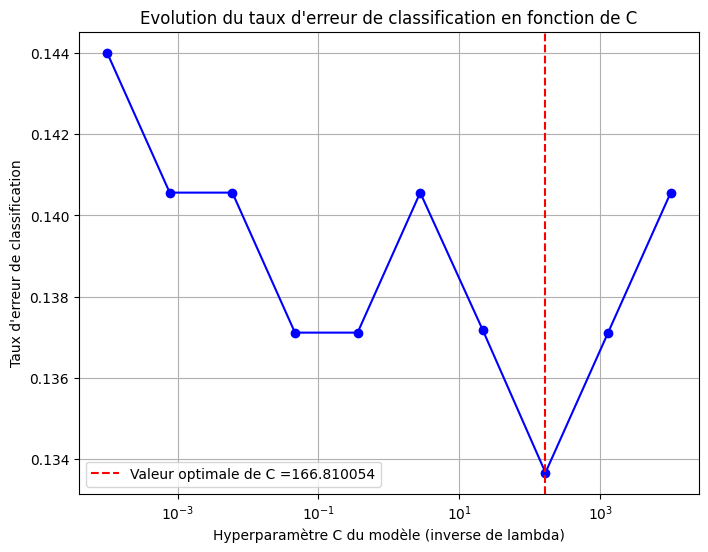

In [66]:
results=grid_search.cv_results_
mean_test_errors = 1-np.array(results['mean_test_score'])
param_C_values = grid_search.cv_results_['param_C'].data
plt.figure(figsize=(8,6))
plt.plot(param_C_values, mean_test_errors, 'o-', color ='b')
plt.xscale('log')
plt.title("Evolution du taux d'erreur de classification en fonction de C")
plt.xlabel('Hyperparamètre C du modèle (inverse de lambda)')
plt.ylabel("Taux d'erreur de classification")
plt.grid(True)
plt.axvline(x=C_optimal, color='r', linestyle='--', label=f'Valeur optimale de C ={round(C_optimal,6)}')
plt.legend()
plt.show()

#### Question 11 :

In [73]:
best_model = LogisticRegression(penalty='l2',solver='liblinear', C=C_optimal)
best_model.fit(Alzheimer_train_data.iloc[:,:-1], Alzheimer_train_data['Y'])
y_pred_best = best_model.predict(Alzheimer_test_data.iloc[:,:-1])
accuracy_best = accuracy_score(Alzheimer_test_data['Y'], y_pred_best)
print("Accuracy du modèle optimal :", accuracy_best)
print("Evaluation du modèle optimal :")
print("Classification report :")
print(classification_report(Alzheimer_test_data['Y'], y_pred_best))

Accuracy du modèle optimal : 0.863013698630137
Evaluation du modèle optimal :
Classification report :
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.90      0.80      0.85        35

    accuracy                           0.86        73
   macro avg       0.87      0.86      0.86        73
weighted avg       0.87      0.86      0.86        73



#### Question 12 :

Nous allons maintenant considérer la régression logistique régularisée $l_1$. Ensuite, nous allons comparer les résultats de ce modèle à ceux de la régression logistique régularisée $l_2$.

In [69]:
model_2 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1) #C est l'inverse du paramètre de régularisation lambda
model_2.fit(Alzheimer_train_data.iloc[:,:-1], Alzheimer_train_data['Y'])
y_pred_2 = model_2.predict(Alzheimer_test_data.iloc[:,:-1])
print("Accuracy de base :", accuracy_score(Alzheimer_test_data['Y'],y_pred_2))
print(classification_report(Alzheimer_test_data['Y'], y_pred_2))

Accuracy de base : 0.8767123287671232
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        38
           1       0.86      0.89      0.87        35

    accuracy                           0.88        73
   macro avg       0.88      0.88      0.88        73
weighted avg       0.88      0.88      0.88        73



In [70]:
nb_folds = 5
C_values = np.logspace(-4,4,10)
param_grid = {'C': C_values}
grid_search_2 = GridSearchCV(model_2, param_grid, cv=nb_folds, scoring='accuracy')
grid_search_2.fit(Alzheimer_train_data.iloc[:,:-1], Alzheimer_train_data['Y'])
C_optimal_2 = grid_search_2.best_params_['C']
best_score_CV_2 = grid_search_2.best_score_
print("Le meilleur paramètre C (inverse de lambda) est :",C_optimal_2)
print("La meilleure accuracy est :", best_score_CV_2)

Le meilleur paramètre C (inverse de lambda) est : 166.81005372000558
La meilleure accuracy est : 0.9003506721215663


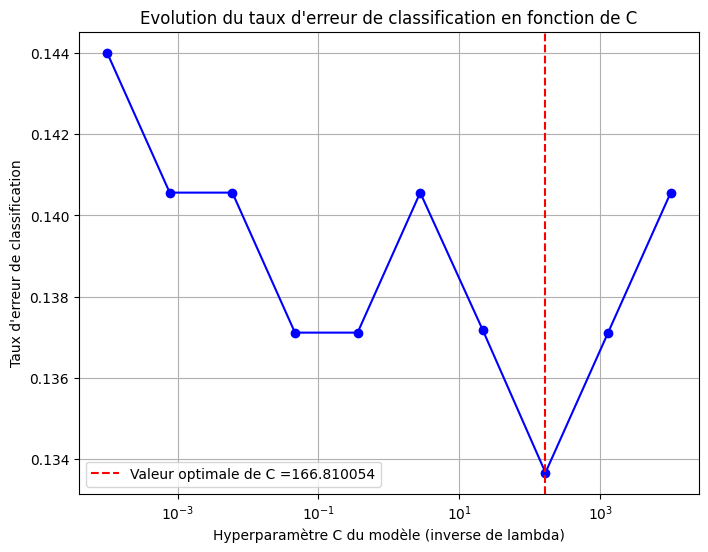

In [71]:
results_2=grid_search_2.cv_results_
mean_test_errors = 1-np.array(results['mean_test_score'])
param_C_values = grid_search_2.cv_results_['param_C'].data
plt.figure(figsize=(8,6))
plt.plot(param_C_values, mean_test_errors, 'o-', color ='b')
plt.xscale('log')
plt.title("Evolution du taux d'erreur de classification en fonction de C")
plt.xlabel('Hyperparamètre C du modèle (inverse de lambda)')
plt.ylabel("Taux d'erreur de classification")
plt.grid(True)
plt.axvline(x=C_optimal_2, color='r', linestyle='--', label=f'Valeur optimale de C ={round(C_optimal_2,6)}')
plt.legend()
plt.show()

In [75]:
best_model_2 = LogisticRegression(penalty='l1',solver='liblinear',C=C_optimal_2)
best_model_2.fit(Alzheimer_train_data.iloc[:,:-1], Alzheimer_train_data['Y'])
y_pred_best_2 = best_model_2.predict(Alzheimer_test_data.iloc[:,:-1])
accuracy_best_2 = accuracy_score(Alzheimer_test_data['Y'], y_pred_best_2)
print("Accuracy du modèle optimal :", accuracy_best_2)
print("Evaluation du modèle optimal :")
print("Classification report :")
print(classification_report(Alzheimer_test_data['Y'], y_pred_best_2))

Accuracy du modèle optimal : 0.9041095890410958
Evaluation du modèle optimal :
Classification report :
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        38
           1       0.94      0.86      0.90        35

    accuracy                           0.90        73
   macro avg       0.91      0.90      0.90        73
weighted avg       0.91      0.90      0.90        73



Ainsi, la régularisation $l_1$ donne de meilleurs résultats que la régularisation $l_2$ avec une accuracy plus élevée et donc un taux d'erreur plus faible. Le $f_1$-score, qui est la moyenne harmonique entre Rappel (Recall) et Précision est aussi plus élevé pour les deux classes.